<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_NN_OrdinalEncoding_0802.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### Data Transformation - Feature Engineer

In [4]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [5]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [6]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [7]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [8]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [9]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [10]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### Ordinal Encoding For Categorical Features

In [11]:
df_tran_1.head()

,age,marital,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,edu_new,job_new,season
0,56,married,no,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,pre_high,blue_collar,spring
1,57,married,unknown,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring
2,37,married,no,yes,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring
3,40,married,no,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,pre_high,white_collar,spring
4,56,married,no,no,yes,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring


In [12]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [13]:
x = df_tran_1.drop('y', axis=1)

In [14]:
x['poutcome'].value_counts()

nonexistent    35547
failure         4251
success         1372
Name: poutcome, dtype: int64

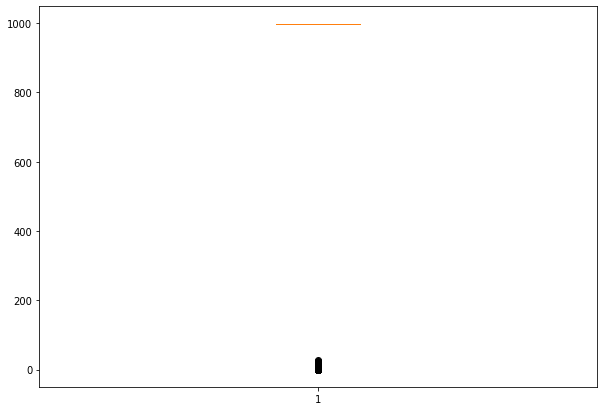

In [15]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(x['pdays'])
plt.show()

In [16]:
#since the neural network does work very well with sparse matrix, one hot encoding might be suitable, here i will test ordinal encoding

x['housing'] = x['housing'].apply(lambda t: 0 if t =='no' else (1 if t=='yes' else -1))
x['default'] = x['default'].apply(lambda t: 0 if t =='no' else (1 if t=='yes' else -1))

#higher weight is assinged to success result of previous campaign
x['poutcome'] = x['poutcome'].apply(lambda t: 0 if t=='failure' else (2 if t=='success' else 1))

#the further it is from the date when the customer was contacted, the lower the value assigned
x['pdays'] = x['pdays'].apply(lambda t: 0 if t==999 else (3 if t<=10 else (2 if t<= 20 else 1)))

x['loan'] = x['loan'].apply(lambda t: 0 if t=='no' else (1 if t=='yes' else -1))

x['contact'] = x['contact'].apply(lambda t: 0 if t=='telephone' else 1)
x['marital'] = x['marital'].apply(lambda t: 1 if t=='married' else 0)

x['edu_new'] = x['edu_new'].apply(lambda t: 3 if t=='post_high' else (2 if t=='high' else (1 if t=='pre_high' else 0)))
x['season'] = x['edu_new'].apply(lambda t: 3 if t=='summer' else (2 if t=='spring' else (1 if t=='fall' else 0)))
x['job_new'] = x['job_new'].apply(lambda t: 3 if t=='blue_collar' else (2 if t=='white_collar' else (1 if t=='not_working' else 0)))

x.head()

,age,marital,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,edu_new,job_new,season
0,56,1,0,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1,3,0
1,57,1,-1,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0
2,37,1,0,1,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0
3,40,1,0,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1,2,0
4,56,1,0,0,1,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0


In [17]:
x = x.drop(['day_of_week'], axis=1)

### Train-Test Split & Data Normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_mm = scaler.fit_transform(x)

In [19]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(x_mm, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 18) (8234, 18) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [20]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [21]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


### Baseline Model - Neural Network 


In [22]:
model = Sequential()
model.add(Flatten(input_shape=( x_s.shape[1],)))
model.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

may need to revisit the kernel initialization and tweaking the model
here is the reference:https://www.kaggle.com/code/trolukovich/glorot-vs-he-weight-initialization-experiment/notebook

In [23]:
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


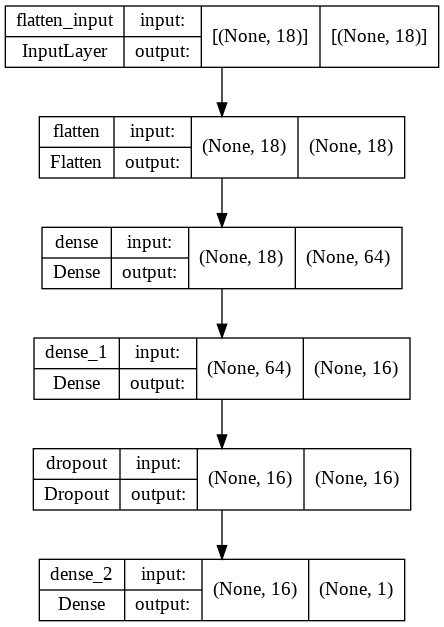

In [24]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [26]:
model_history = model.fit(x_s, y_s,validation_split=0.33, batch_size = 100, epochs = 100)

Epoch 1/100
392/392 [==============================] - 2s 6ms/step - loss: 0.4767 - precision: 0.7198 - val_loss: 1.1111 - val_precision: 1.0000
Epoch 2/100
392/392 [==============================] - 2s 6ms/step - loss: 0.4727 - precision: 0.7136 - val_loss: 1.1110 - val_precision: 1.0000
Epoch 3/100
392/392 [==============================] - 1s 4ms/step - loss: 0.4683 - precision: 0.7106 - val_loss: 1.0345 - val_precision: 1.0000
Epoch 4/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4656 - precision: 0.7186 - val_loss: 1.0442 - val_precision: 1.0000
Epoch 5/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4633 - precision: 0.7093 - val_loss: 1.0678 - val_precision: 1.0000
Epoch 6/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4618 - precision: 0.7111 - val_loss: 1.0685 - val_precision: 1.0000
Epoch 7/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4609 - precision: 0.7111 - val_loss: 1.0744 - val_pre

In [27]:
from sklearn.metrics import cohen_kappa_score,  average_precision_score


# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print("Kappa- ", cohen_kappa_score(y_test, predictions))
    print("F1- ", f1_score(y_test, predictions))
    print("ROC_AUC_score- ", roc_auc_score(y_test, predictions))
    print("PR AUC- ", average_precision_score(y_test, predictions))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_curve(y_test, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    fig.tight_layout()
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, predictions)
    ax2.set_title('Precision-Recall AUC Curve')
    ax2.plot(lr_recall, lr_precision, marker='.')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.show()

####Evaluate the model - threshold 0.5

In [41]:
preds_50 = model.predict(x_test)
preds_50 =  [1 if i>0.5 else 0 for i in preds_50]

In [42]:
print_validation_report(y_test, preds_50)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7307
           1       0.52      0.41      0.46       927

    accuracy                           0.89      8234
   macro avg       0.72      0.68      0.70      8234
weighted avg       0.88      0.89      0.89      8234

Accuracy Score: 0.8913043478260869
Kappa-  0.40162983631320903
F1-  0.4611679711017459
ROC_AUC_score-  0.6825623019052381
PR AUC-  0.2816541201955417


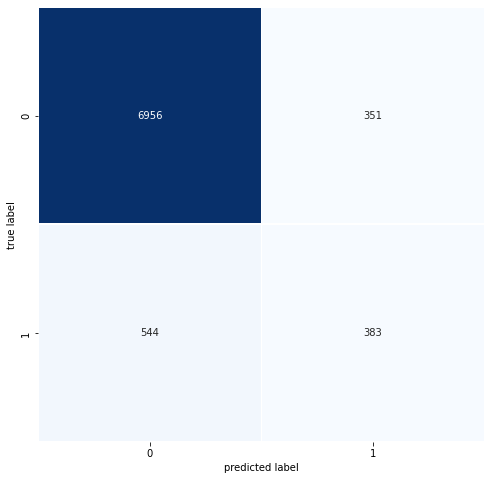

In [43]:
plot_confusion_matrix(y_test, preds_50)

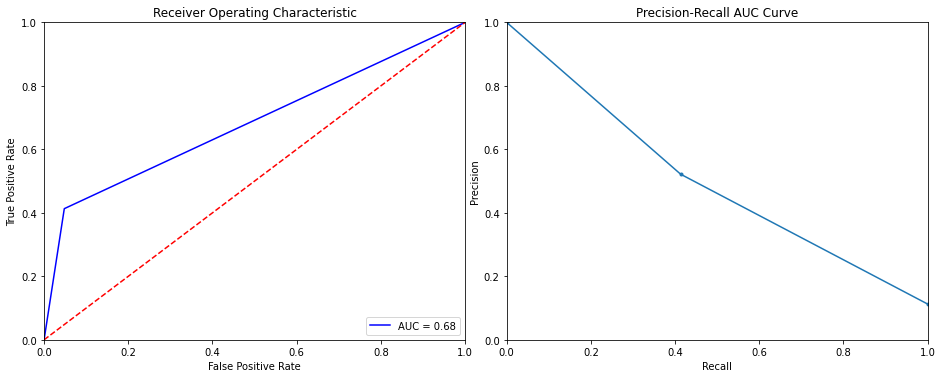

In [44]:
plot_curve(y_test, preds_50)

####Evaluate the model - threshold 0.7

In [45]:
preds_70 = model.predict(x_test)
preds_70 =  [1 if i>0.7 else 0 for i in preds_70]

In [47]:
print_validation_report(y_test, preds_70)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7307
           1       0.69      0.23      0.34       927

    accuracy                           0.90      8234
   macro avg       0.80      0.61      0.64      8234
weighted avg       0.89      0.90      0.88      8234

Accuracy Score: 0.901505950935147
Kappa-  0.301464547236842
F1-  0.34011391375101707
ROC_AUC_score-  0.6063654733111206
PR AUC-  0.24322862184918198


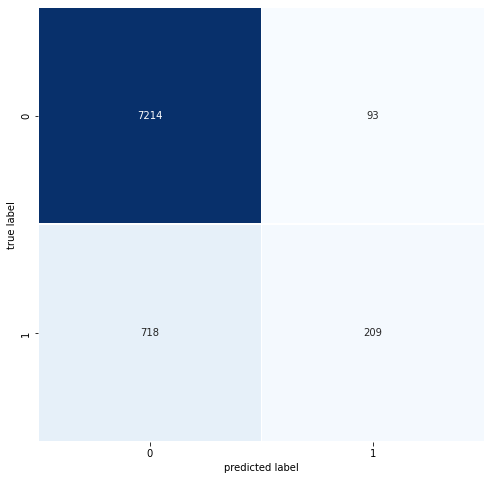

In [48]:
plot_confusion_matrix(y_test, preds_70)

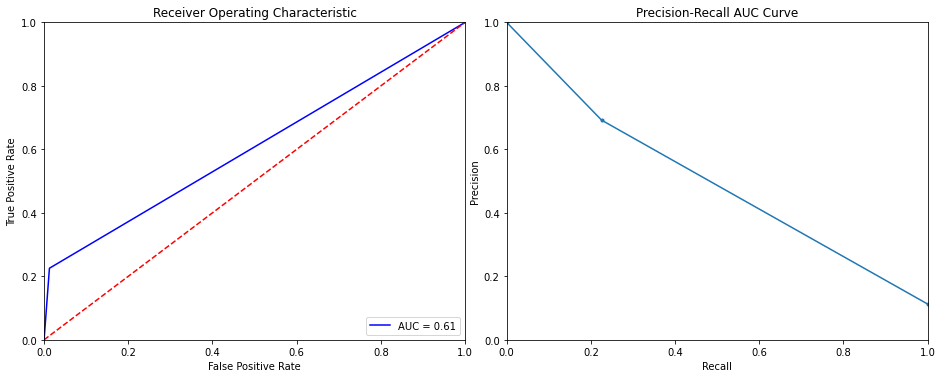

In [49]:
plot_curve(y_test, preds_70)

####Evaluate the model - threshold 0.3

In [52]:
preds_30 = model.predict(x_test)
preds_30 =  [1 if i>0.3 else 0 for i in preds_30]

In [53]:
print_validation_report(y_test, preds_30)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      7307
           1       0.40      0.60      0.48       927

    accuracy                           0.85      8234
   macro avg       0.67      0.74      0.70      8234
weighted avg       0.88      0.85      0.87      8234

Accuracy Score: 0.8531697838231722
Kappa-  0.39949937500294075
F1-  0.480893087161872
ROC_AUC_score-  0.7444336377657398
PR AUC-  0.2858662805947412


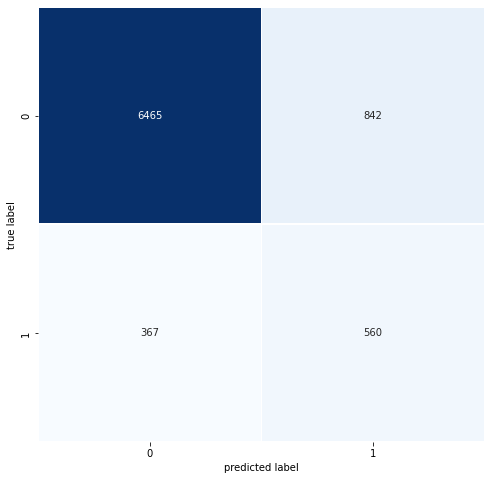

In [54]:
plot_confusion_matrix(y_test, preds_30)

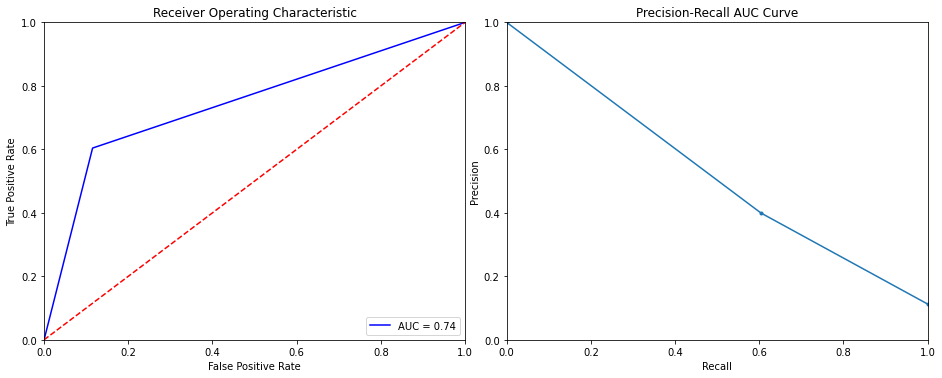

In [55]:
plot_curve(y_test, preds_30)

### Use sklearn MLPClassifier for comparison purpose

In [56]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,200,50), max_iter=300, activation='relu', solver='adam', random_state=1)
mlp.fit(x_s, y_s)

MLPClassifier(hidden_layer_sizes=(50, 200, 50), max_iter=300, random_state=1)

In [64]:
preds_mlp_50 = mlp.predict(x_test)
preds_mlp_50 =  [1 if i>0.5 else 0 for i in preds_mlp_50]

In [65]:
print_validation_report(y_test, preds_mlp_50)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7307
           1       0.25      0.47      0.33       927

    accuracy                           0.78      8234
   macro avg       0.59      0.65      0.60      8234
weighted avg       0.85      0.78      0.81      8234

Accuracy Score: 0.7839446198688366
Kappa-  0.21165235580995168
F1-  0.3269012485811578
ROC_AUC_score-  0.6451487534894722
PR AUC-  0.1774361633800711


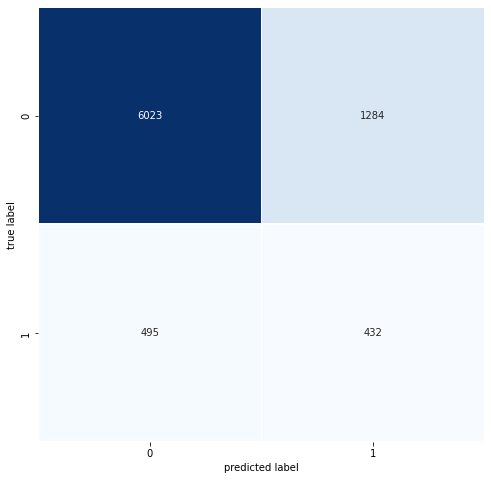

In [66]:
plot_confusion_matrix(y_test, preds_mlp_50)

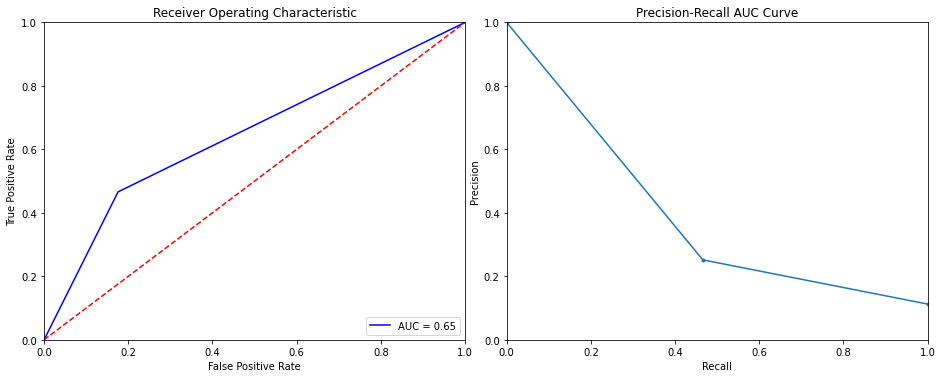

In [67]:
plot_curve(y_test, preds_mlp_50)

### Different Approach to deal with imblanaced Data - Neural Network Model Balanced Weight 

In [74]:
#calculate weights using sklearn
#sklearn has a built-in utility function compute_class_weight to calculate the class weights. The weights are calculated using the inverse proportion of class frequencies.

from sklearn.utils import class_weight

sklearn_weights = class_weight.compute_class_weight(class_weight ='balanced', 
                                                    classes = np.unique(y_train), 
                                                    y = y_train)
sklearn_weights

array([0.5634516 , 4.44001078])

In [75]:
#The computed weights from sklearn are in array format. We need to transform it into a dictionary because Keras takes a dictionary as inputs.
sklearn_weights = dict(enumerate(sklearn_weights))
sklearn_weights

{0: 0.5634516029698566, 1: 4.440010784578053}

In [76]:
# use x_train, x_test are not oversampling with SMOTE
#architecture remained same as baseline model

model_w = Sequential()
model_w.add(Flatten(input_shape=(x_train.shape[1],)))
model_w.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model_w.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_w.add(Dropout(0.2))
model_w.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [79]:
model_w.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_w.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                1216      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_w_history = model_w.fit(x_train, y_train,validation_split=0.33, batch_size = 100, epochs = 100, class_weight=sklearn_weights)

Epoch 1/100
221/221 [==============================] - 1s 3ms/step - loss: 0.5562 - accuracy: 0.7976 - val_loss: 0.5393 - val_accuracy: 0.8000
Epoch 2/100
221/221 [==============================] - 1s 2ms/step - loss: 0.5526 - accuracy: 0.8025 - val_loss: 0.5447 - val_accuracy: 0.7950
Epoch 3/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5540 - accuracy: 0.8020 - val_loss: 0.5177 - val_accuracy: 0.8195
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5546 - accuracy: 0.7994 - val_loss: 0.5486 - val_accuracy: 0.7928
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5539 - accuracy: 0.8000 - val_loss: 0.5326 - val_accuracy: 0.7999
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.8002 - val_loss: 0.5444 - val_accuracy: 0.7965
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5526 - accuracy: 0.8031 - val_loss: 0.5400 - val_accuracy: 0.7964

In [85]:
preds_w_50 = model_w.predict(x_test)
preds_w_50 =  [1 if i>0.5 else 0 for i in preds_w_50]

In [86]:
print_validation_report(y_test, preds_w_50)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      7307
           1       0.33      0.67      0.45       927

    accuracy                           0.81      8234
   macro avg       0.64      0.75      0.67      8234
weighted avg       0.88      0.81      0.84      8234

Accuracy Score: 0.8118775807626912
Kappa-  0.34719688271029614
F1-  0.44539921231650553
ROC_AUC_score-  0.7503669767976768
PR AUC-  0.2607020888560137


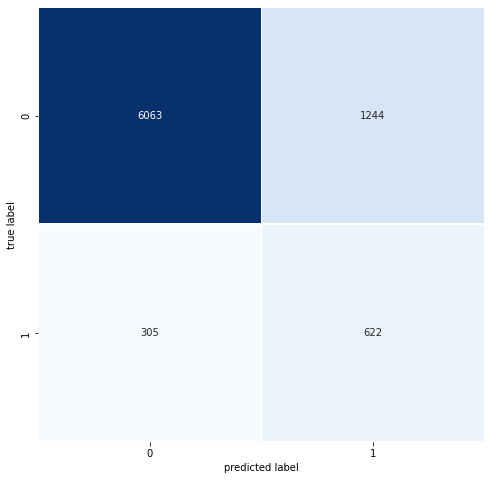

In [87]:
plot_confusion_matrix(y_test, preds_w_50)

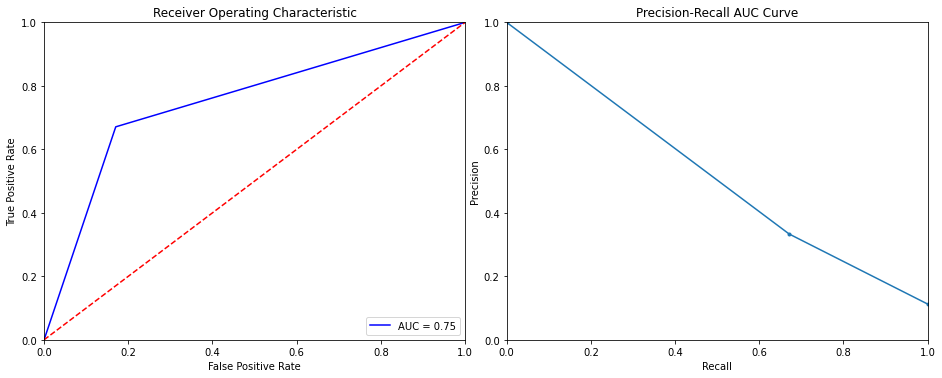

In [88]:
plot_curve(y_test, preds_w_50)

### Manual Balance Weight On Neural Network Model 

In [89]:
#instead using the weights calculated based on inverse proportion of class frequencies

#we can use monetary value as penalty ratio
# losing a true postive will lose $400
# cost of playing a cold call to customer is $10

manual_weights = {0: 1, 1: 40}

In [90]:
model_m = Sequential()
model_m.add(Flatten(input_shape=(x_train.shape[1],)))
model_m.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model_m.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_m.add(Dropout(0.2))
model_m.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [91]:
model_m.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 18)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                1216      
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


In [92]:
model_m_history = model_m.fit(x_train, y_train,validation_split=0.33, batch_size = 100, epochs = 100, class_weight=manual_weights)

Epoch 1/100
221/221 [==============================] - 1s 3ms/step - loss: 2.8676 - accuracy: 0.1538 - val_loss: 1.5370 - val_accuracy: 0.1132
Epoch 2/100
221/221 [==============================] - 1s 2ms/step - loss: 2.3872 - accuracy: 0.1297 - val_loss: 1.4711 - val_accuracy: 0.1138
Epoch 3/100
221/221 [==============================] - 1s 2ms/step - loss: 2.2936 - accuracy: 0.1282 - val_loss: 1.4523 - val_accuracy: 0.1136
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 2.2561 - accuracy: 0.1243 - val_loss: 1.4256 - val_accuracy: 0.1132
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 2.2196 - accuracy: 0.1165 - val_loss: 1.4476 - val_accuracy: 0.1132
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 2.2013 - accuracy: 0.1133 - val_loss: 1.4017 - val_accuracy: 0.1132
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 2.1895 - accuracy: 0.1128 - val_loss: 1.3761 - val_accuracy: 0.1132

In [99]:
preds_m_50 = model_m.predict(x_test)
preds_m_50 =  [1 if i>0.5 else 0 for i in preds_m_50]

In [100]:
print_validation_report(y_test, preds_m_50)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7307
           1       0.11      1.00      0.20       927

    accuracy                           0.11      8234
   macro avg       0.56      0.50      0.10      8234
weighted avg       0.90      0.11      0.02      8234

Accuracy Score: 0.1136750060723828
Kappa-  0.00027759838896435074
F1-  0.20257867132867136
ROC_AUC_score-  0.5006158478171616
PR AUC-  0.11270516717325228


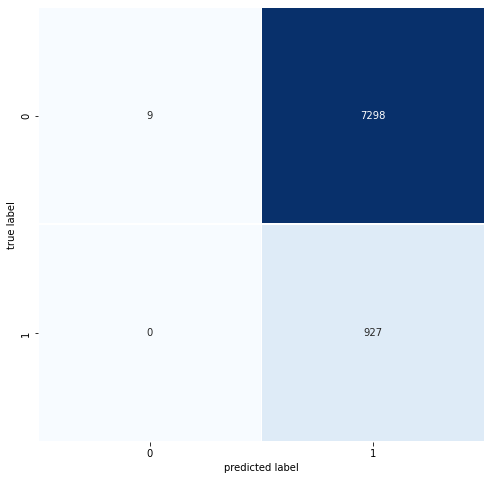

In [101]:
plot_confusion_matrix(y_test, preds_m_50)

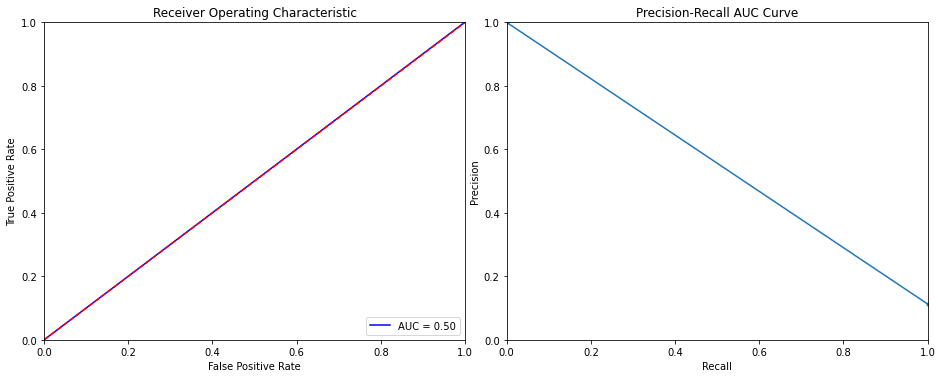

In [102]:
plot_curve(y_test, preds_m_50)